# Overview of notebook
This auxiliary notebook contains code that helps the lectures to collect data and generate plots.


- [Voronoi functions](#Voronoi-functions)
- [Administrative areas of Denmark](#Administrative-areas-of-Denmark)
- Making static maps 
    - [Youth around Copenhagen from Statistics Denmark](#Plotting-Youth-around-Copenhagen)
    - [Danish House prices](#House-price-plots)
- Making interactive maps     
    - [Amenities in Open Street Maps](#Plotting-Amenities-from-Open-Street-Maps)
- Schools boundaries data

### Load packages

In [52]:
import json
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely

from shapely.geometry import Point, LineString, Polygon, MultiPolygon

def convert_to_danish_crs(df):
    df.to_crs(epsg=25832, inplace=True)

# Voronoi functions


In [54]:
from voronoi import voronoi_wrapper, make_vor_plot

# Administrative areas of Denmark

We start off by loading adminstrative shape files for parishes and municipalities


In [13]:
dawa_api = 'https://dawa.aws.dk/'

# parishes (church districts)
sogne = gpd.read_file(dawa_api + 'sogne?format=geojson')    

# municipalities
kommuner = gpd.read_file(dawa_api + 'kommuner?format=geojson')

# rename columns and change coordinate system
for gdf in sogne, kommuner:
    gdf.columns = gdf.columns.str.lower()
    gdf.to_crs(epsg=25832, inplace=True)

# CPH bounds    
kbh_bounds = kommuner[kommuner.navn=='København'].unary_union.bounds    
    
# select Copenhagen shapes
select_cph = kommuner.navn.isin(['København', 'Frederiksberg'])
kommuner_cph = kommuner[select_cph]

From the administrative areas we can make unified shapes

In [28]:
# DK as one shape
denmark_shape = kommuner.unary_union

# Capital region (without Bornholm) as one shape
cap_reg = kommuner.regionsnavn.isin(['Region Hovedstaden'])
non_bornholm = kommuner.bounds.minx<800000

kommuner_select = kommuner[cap_reg & non_bornholm]
cap_region = kommuner_select.unary_union

# Capital region (without Bornholm) as one shape
sealand_reg = kommuner.regionsnavn.isin(['Region Hovedstaden', 'Region Sjælland'])
non_bornholm = ~ kommuner.navn.isin(['Bornholm', 'Christiansø'])

kommuner_select_sealand = kommuner[sealand_reg & non_bornholm]
sealand_shape = kommuner_select_sealand.unary_union

# Plotting youth around Copenhagen

We plot youth data in the region around Copenhagen. We use the example DST api and merge with municipal and parish shapes.


### Pull data from API

In [38]:
%run auxiliary_statistics_denmark_api.ipynb

https://api.statbank.dk/v1/data/KM5/csv?valuePresentation=Default&timeOrder=Ascending&allowVariablesInHead=true&SOGN=*&TID=2010%2C2011%2C2012%2C2013%2C2014&ALDER=*
https://api.statbank.dk/v1/data/FOLK1A/csv?valuePresentation=Default&timeOrder=Ascending&allowVariablesInHead=true&OMRÅDE=*&TID=2008K1%2C2009K1%2C2010K1&ALDER=*


### Merge data with shapes

In [46]:
# kommuner_unary_gs = kommuner.groupby('komnavn').apply(lambda gdf: gdf.unary_union)
# kommuner_unary = gpd.GeoDataFrame(data={'komnavn':kommuner_unary_gs.index},
#                                   geometry=kommuner_unary_gs.values)

In [34]:
gdf_mun_young = kommuner.merge(youth_stats_mun[youth_stats_mun.year==2010])
gdf_mun_young_cap_reg = gdf_mun_young[gdf_mun_young.intersects(cap_region)]

In [39]:
gdf_parish_young = sogne.merge(youth_stats[youth_stats.year==2010])
        
# select capital region 
gdf_parish_young_cap_reg = gdf_parish_young[gdf_parish_young.intersects(cap_region)]

### Municipality- plot youth count

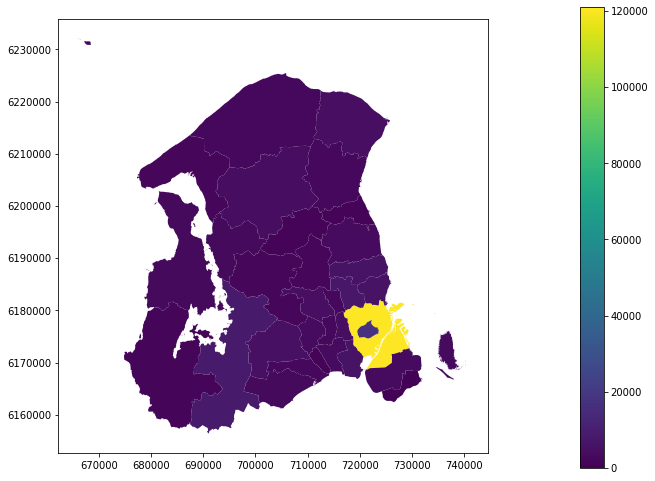

In [40]:
count_max = gdf_mun_young_cap_reg['Count of young (20-30)'].max()

vmin, vmax = 0, count_max
ax = gdf_mun_young_cap_reg\
    .plot(column=c_count, 
          figsize=(11,8), 
          vmin=vmin, 
          vmax=vmax,
          cmap='viridis')

# add colorbar
f_cph_young_count_mun = ax.get_figure()
cax = f_cph_young_count_mun.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
f_cph_young_count_mun.colorbar(sm, cax=cax)

### Municipality - plot youth share

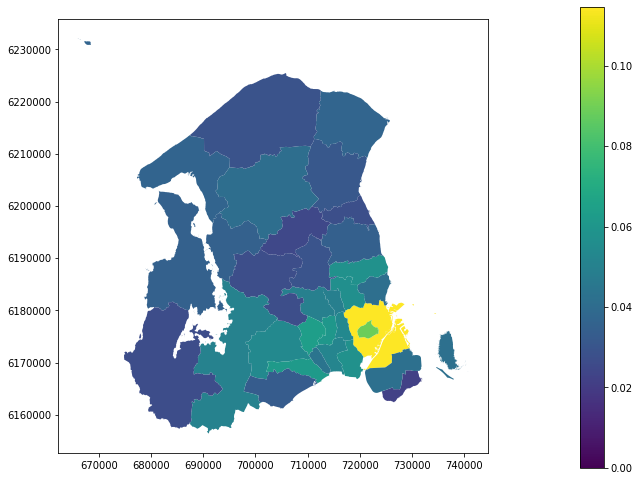

In [41]:
share_max = gdf_mun_young_cap_reg['Share of young (20-30)'].max()

vmin, vmax = 0, share_max
ax = gdf_mun_young_cap_reg\
    .plot(column=c_share, 
          figsize=(11,8), 
          vmin=vmin, 
          vmax=vmax,
          cmap='viridis')

# add colorbar
f_cph_young_share_mun = ax.get_figure()
cax = f_cph_young_share_mun.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
f_cph_young_share_mun.colorbar(sm, cax=cax)

### Parish - plot youth count

C:\Users\bvq720\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


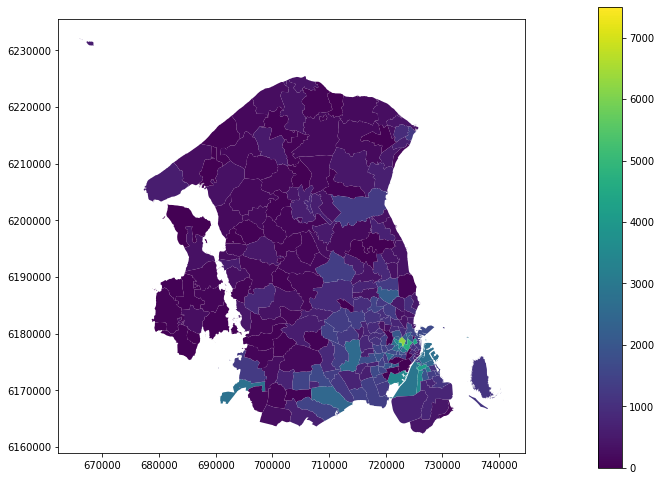

In [42]:
vmin, vmax = 0, 7500
ax = gdf_parish_young_cap_reg\
    .plot(column=c_count, 
          figsize=(11,8), 
          vmin=vmin, 
          vmax=vmax,
          cmap='viridis')

# add colorbar
f_cph_young_count = ax.get_figure()
cax = f_cph_young_count.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
f_cph_young_count.colorbar(sm, cax=cax)

### Parish - plot youth share

C:\Users\bvq720\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


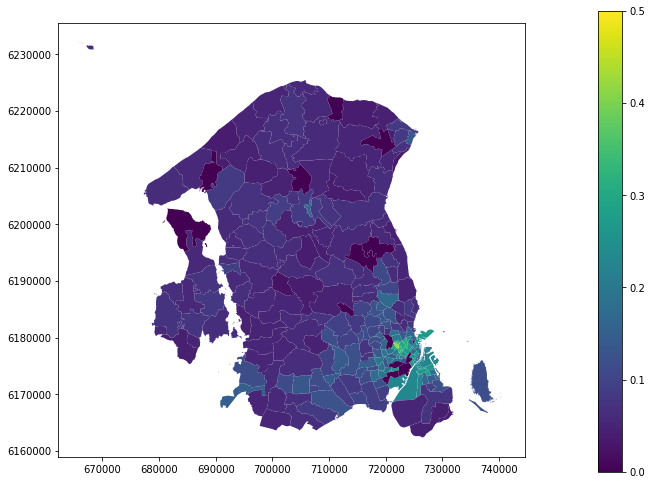

In [43]:
vmin, vmax = 0, .5
ax = gdf_parish_young_cap_reg\
        .plot(column=c_share, 
              figsize=(11,8), 
              vmin=vmin, 
              vmax=vmax,
              cmap='viridis')

# add colorbar
f_cph_young_share = ax.get_figure()
cax = f_cph_young_share.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
f_cph_young_share.colorbar(sm, cax=cax)

# House price plots

We plot data from Danish house prices. Note this data is collected from [Snorre's code for scraping](https://github.com/abjer/tsds2018/blob/master/data/scraping_examples/scraping-boligsiden.ipynb). It is also made available in a structured format in the internal course page.

<p><FONT color=red>You need to have downloaded the data before starting this script. See the accompanying exercises for instructions.</FONT></p>


In [44]:
price_gdf = gpd.read_file('house_prices.geojson')

Select 2012 price sales data and make Voronoi

In [45]:
# some address coordinates have multiple sales
# we handle this by making a slight perturbation
price_gdf['n'] = price_gdf.geometry.y
price_gdf['e'] = price_gdf.geometry.x

price_gdf[['e', 'n']] += np.random.normal(scale=100, size=(len(price_gdf), 2))

# select 2012 sales and remove outliers
selection = (price_gdf.sale_year==2012) & \
            (price_gdf.price_area.between(1000,100000))

# make selection, reset_index and copy
prices_12 = price_gdf[selection].reset_index(drop=True).copy()



Voronoi prices

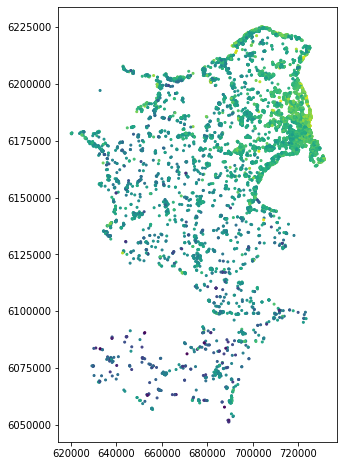

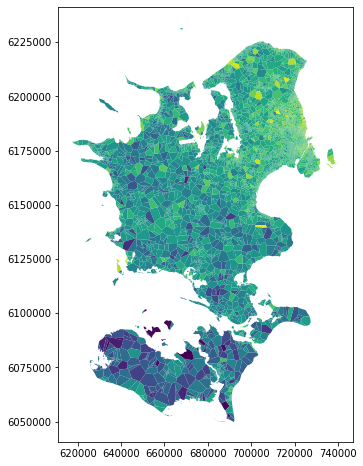

In [46]:
# make voronoi shapes
voronoi_geom = voronoi_wrapper(prices_12[['e', 'n']].copy(), 
                               sealand_shape)

# turn into new GeoDataFrame for plotting
prices_12_vor = gpd.GeoDataFrame(data=prices_12.copy().drop('geometry',axis=1),
                                 geometry=voronoi_geom)

# make plots
f_price_pointcloud,ax = plt.subplots(figsize=(10,8))
prices_12.plot(column='price_area_log', markersize=4, ax=ax)

f_price_voronoi,ax = plt.subplots(figsize=(10,8))
prices_12_vor.plot(column='price_area_log', ax=ax)

# Plotting Amenities from Open Street Maps 

We pull data from the Open Street Maps API and visualize it.

In [47]:
from shapely.geometry import Point


overpass_base = "http://overpass-api.de/api/interpreter"

def query_overpass_gdf(tag, subtag='*', place='DK'):
    q = f"""
         [out:json];
         area["ISO3166-1"="{place}"][admin_level=2];
         (node["{tag}"="{subtag}"](area);
          way["{tag}"="{subtag}"](area);
          rel["{tag}"="{subtag}"](area);
         );
         out center;
         """
    
    response = requests.get(overpass_base, params={'data': q})    
    df = pd.DataFrame(response.json()['elements'])
    
    points = df[['lon','lat']].apply(Point, 1)
    gdf = gpd.GeoDataFrame(df,
                           geometry = points,
                           crs = {'init': 'epsg:4326'})

    gdf.to_crs(epsg=25832, inplace=True)
    
    return gdf

### Restaurant plots

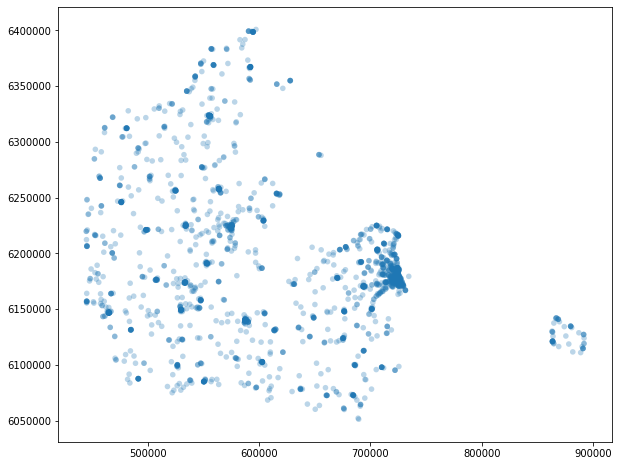

In [48]:
gdf_restaurant = query_overpass_gdf('amenity', 'restaurant')
f_restaurant_buffer, ax = plt.subplots(figsize=(14,8))
gs_rest_1km = gdf_restaurant.buffer(2500)
gs_rest_1km.plot(alpha=.3, ax=ax)

### Supermarket plots

In [49]:
gdf_supermarket = query_overpass_gdf('shop', 'supermarket')
gdf_supermarket['name'] = gdf_supermarket.tags.str['name'].fillna('')

In [50]:
from folium.plugins import MarkerCluster

m_dk_supermarket_cph = folium.Map(location=[55.7, 12.5],
                              tiles='Stamen Toner',
                              zoom_start=10)

marker_cluster_cph = MarkerCluster(
    overlay=True,
    control=False,
    icon_create_function=None)

In [51]:
from folium.plugins import MarkerCluster

m_dk_supermarket = folium.Map(location=[55.7, 12.5],
                              tiles='Stamen Toner',
                              zoom_start=10)

marker_cluster = MarkerCluster(
    overlay=True,
    control=False,
    icon_create_function=None)

geoms = gdf_supermarket.set_index('name')[['lat','lon']].iterrows()
for name, point in geoms:        
    marker = folium.Marker(location=[point.lat, point.lon])
    n = name.replace('ø','oe').replace('å','aa').replace('æ','ae').replace("'",'')
    
    popup = n
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)
    
marker_cluster.add_to(m_dk_supermarket)

m_dk_supermarket  

### Schools data

In [ ]:
import geopandas as gpd
%matplotlib inline

url_school = \
    'http://wfs-kbhkort.kk.dk/k101/ows?'+\
    'service=WFS&version=1.0.0&request=GetFeature'+\
    '&typeName=k101:skolegrunddistrikt&outputFormat=json'+\
    '&SRSNAME=EPSG:4326'

gdf_school = gpd.read_file(url_school).to_crs(epsg=25832)